<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import time
from statsmodels.graphics import tsaplots

In [ ]:
df = pd.read_csv('/datasets/taxi.csv',index_col=[0],parse_dates = [0])
df.sort_index(inplace=True)
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим данные на пропуски

In [ ]:
df.isna().sum()

num_orders    0
dtype: int64

Выполним ресемплирование данных по 1му часу

In [ ]:
df = df.resample('1H').sum()

<AxesSubplot:xlabel='datetime'>

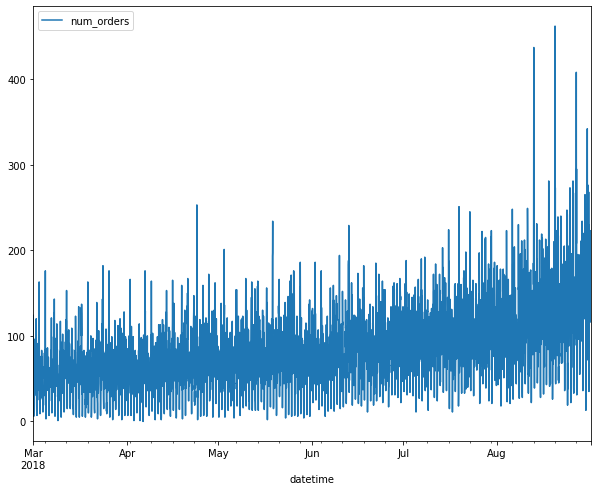

In [ ]:

df.plot(figsize=(10,8))

***Вывод:
Представлены данные за период март-сентябрь 2018 годаю.
Пропусков в данных не имеется.
Данные сгруппированы(ресемплированны) периодом в 1 час.
Из графика видим сезонность в летние месяцы( в августе в пиковое часы, кол-во заказов в два раза выше, чем  в весенние месяцы). Среднее пиковое значение в районе 200 заказанных такси в час.***

## Анализ

Посмотрим тренд, сезонность и шумы

In [ ]:
decomposed = seasonal_decompose(df)

Text(0.5, 1.0, 'Trend')

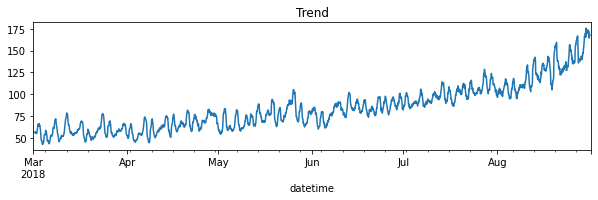

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

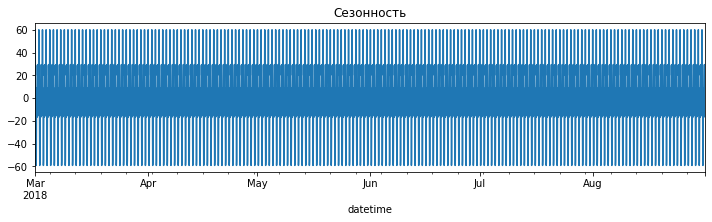

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca())
plt.title('Сезонность')
plt.tight_layout()

Уменьшим временной интервал до 1го дня, что бы можно было увидеть сезонность внутри дня

Text(0.5, 1.0, 'Seasonality')

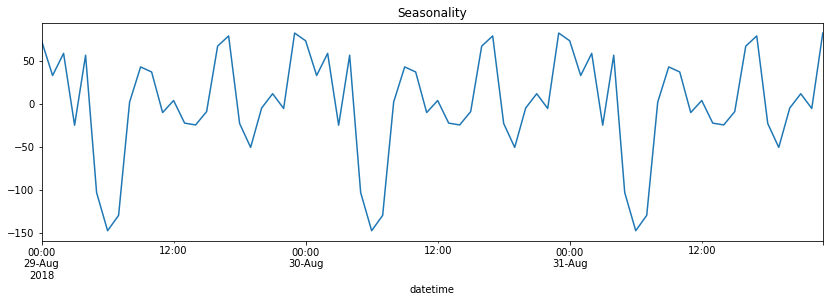

In [ ]:
decomposed = seasonal_decompose(df['2018-08-29':'2018-08-31'])
decomposed.seasonal.plot(figsize=(14, 4))
plt.title('Seasonality')

Посмотрим сезонность внутри недели

Text(0.5, 1.0, 'Seasonality')

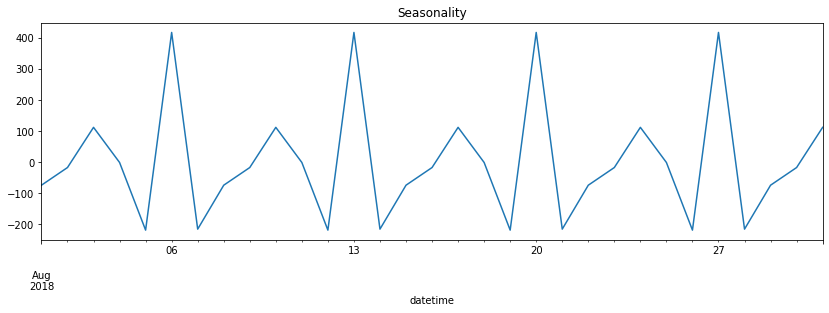

In [ ]:
df1 = df.copy()
df1 = df1.resample('1D').sum()
decomposed = seasonal_decompose(df1['2018-08-01':'2018-08-31'])
decomposed.seasonal.plot(figsize=(14, 4))
plt.title('Seasonality')

График сезонности показывает, что ночью с 00:00 число заказов начинает снижаться и самое малое колличество заказов около 6:00, далее наблюдается рост вплоть до полуночи.
Самый высокий спрос на такси в пятницу и понедельник

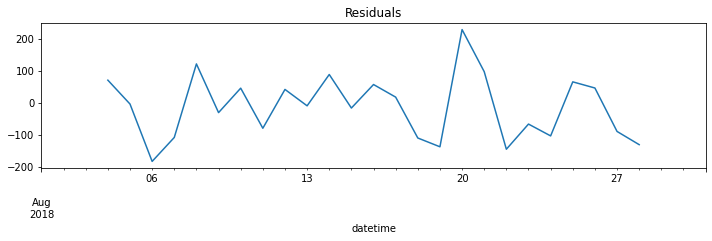

In [ ]:

plt.figure(figsize=(10,8))
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())# < напишите код здесь >
plt.title('Residuals')
plt.tight_layout()

*Визуально на графике тренда видно что временной ряд не стационарен(среднее и дисперсия меняется с течением времени)*

Проведем тест Дики-Фуллера.
H 0 : Временной ряд является нестационарным. Другими словами, он имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени.

H A : временной ряд является стационарным.

Если p-значение из теста меньше некоторого уровня значимости (например, α = 0,05), то мы можем отвергнуть нулевую гипотезу и сделать вывод, что временной ряд является стационарным.

In [ ]:
from statsmodels. tsa.stattools import adfuller
test = adfuller(df['num_orders'])
print('P_value = ',test[1])
print(f'Критерий ряда {test[0]}\nКритерий 5% {test[4]["5%"]}')

P_value =  0.028940051402612906
Критерий ряда -3.0689242890279558
Критерий 5% -2.8621993540813637


*Исходя из теста, видим что процесс стационарный. С вероятностью ошибки первого рода равной 5% (на грани)*

## Обучение

Посмотрим график автокорреляции, для подбора параметра lag

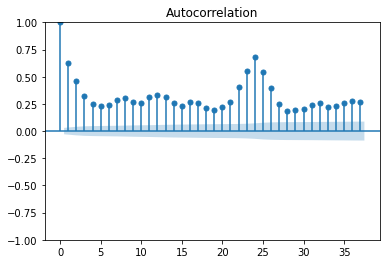

In [ ]:
# импортируем автокорреляционную функцию (ACF)
from statsmodels.graphics.tsaplots import plot_acf

# применим функцию к нашему набору данных

plot_acf(df)
plt.show()

Как видим из графика, лаг 24 коррелирует сильнее всего к исходному ряду


*Создадим признаки для горизонта прогнозирования в один шаг.*

In [ ]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()


In [ ]:
make_features(df, 24, 24)

Разделим данные на trein,test,valid. Тестовой выборке отдадим 10% данных,60% на обучение, 30% на валидацию.

In [ ]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
train, valid = train_test_split(train, shuffle=False, test_size=0.3)


features_train = train.drop(['num_orders'],axis = 1)# < напишите код здесь >
target_train = train['num_orders']
features_test = test.drop(['num_orders'],axis = 1)# < напишите код здесь >
target_test = test['num_orders']
features_valid = valid.drop(['num_orders'],axis = 1)
target_valid = valid['num_orders']

*Обучим модели*

Линейная регрессия

In [ ]:
%%time
lr = LinearRegression()
lr.fit(features_train, target_train)
predicted_train = lr.predict(features_train)
predictions_valid = lr.predict(features_valid)
print('RMSE на валидной выборке',mean_squared_error(predictions_valid, target_valid)**.5)

RMSE на валидной выборке 31.344788302906583
CPU times: user 108 ms, sys: 153 ms, total: 261 ms
Wall time: 140 ms


RMSE линейной регрессии на валидной выборке 31.3

In [ ]:
%%time
for est in range(1, 202, 20):
    for depth in range(3, 6):
        model_forest = RandomForestRegressor(random_state=12345, n_estimators= est,max_depth=depth)
        model_forest.fit(features_train, target_train)
        predictions_forest_valid = model_forest.predict(features_valid)
        print("Глубина дерева:", depth,'n_estimators:',est,'RMSE',mean_squared_error(predictions_forest_valid, target_valid)**.5)


Глубина дерева: 3 n_estimators: 1 RMSE 38.657276249471316
Глубина дерева: 4 n_estimators: 1 RMSE 36.22822477332495
Глубина дерева: 5 n_estimators: 1 RMSE 37.27647007090783
Глубина дерева: 3 n_estimators: 21 RMSE 37.49301103419672
Глубина дерева: 4 n_estimators: 21 RMSE 35.337096627456
Глубина дерева: 5 n_estimators: 21 RMSE 34.298715557563895
Глубина дерева: 3 n_estimators: 41 RMSE 37.42451700207333
Глубина дерева: 4 n_estimators: 41 RMSE 35.29742006265898
Глубина дерева: 5 n_estimators: 41 RMSE 34.09320992656639
Глубина дерева: 3 n_estimators: 61 RMSE 37.220312878450244
Глубина дерева: 4 n_estimators: 61 RMSE 35.35396504046194
Глубина дерева: 5 n_estimators: 61 RMSE 34.009060065063636
Глубина дерева: 3 n_estimators: 81 RMSE 37.17766978487433
Глубина дерева: 4 n_estimators: 81 RMSE 35.31283566383305
Глубина дерева: 5 n_estimators: 81 RMSE 34.015203623187574
Глубина дерева: 3 n_estimators: 101 RMSE 37.27996262423024
Глубина дерева: 4 n_estimators: 101 RMSE 35.42434436612809
Глубина дере

Лучший показатель RMSE 34.00  у случайного леса при гиперпараметрах Глубина дерева: 5 n_estimators: 61


Модель CatBoost

In [ ]:
%time
cat = CatBoostRegressor(n_estimators=30,
                       loss_function='RMSE',
                       learning_rate=0.4,
                       depth=3,
                       task_type='CPU',
                       random_state=42,
                       verbose=False)
cat.fit(features_train, target_train)
predicted_valid = cat.predict(features_valid)
print("RMSE валидационной выборки ", mean_squared_error(target_valid, predicted_valid) ** 0.5)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
RMSE валидационной выборки  30.879088953977732


*RMSE модели CatBoostRegressor = 30.87*

Модель LightGBM

In [ ]:
%%time
for depth in range(1, 9, 3):
    for num in range(30, 121, 30):
        model = lgb.LGBMRegressor(max_depth = depth,num_leaves= num,random_state=12345)
        model.fit(features_train, target_train)
        predictions_train = model.predict(features_valid)
        print("max_depth:", depth,'num_leaves:',num,'rmse',mean_squared_error(target_valid, predictions_train)**0.5)

max_depth: 1 num_leaves: 30 rmse 34.468040116972396
max_depth: 1 num_leaves: 60 rmse 34.468040116972396
max_depth: 1 num_leaves: 90 rmse 34.468040116972396
max_depth: 1 num_leaves: 120 rmse 34.468040116972396
max_depth: 4 num_leaves: 30 rmse 30.370163389867464
max_depth: 4 num_leaves: 60 rmse 30.370163389867464
max_depth: 4 num_leaves: 90 rmse 30.370163389867464
max_depth: 4 num_leaves: 120 rmse 30.370163389867464
max_depth: 7 num_leaves: 30 rmse 30.593921189908507
max_depth: 7 num_leaves: 60 rmse 30.985988104124814
max_depth: 7 num_leaves: 90 rmse 30.913601766956397
max_depth: 7 num_leaves: 120 rmse 30.913601766956397
CPU times: user 24min 37s, sys: 9.65 s, total: 24min 46s
Wall time: 24min 57s


*Лучший показатель rmse 30.3 модели LightGBM, при гиперпараметрах max_depth: 4 num_leaves: 30*


Сравним модели

In [ ]:
analysis = [[ 'Случайный лес', 34.00],
            [ 'Линейная регрессия', 31.3],
            ['CatBoostRegressor', 30.87],
            ['LightGBM', 30.37]]
columns = ['Модель','RMSE']
analysis_data = pd.DataFrame(data=analysis, columns=columns)
analysis_data.sort_values(by='RMSE', axis=0).reset_index(drop=True)

,Модель,RMSE
0,LightGBM,30.37
1,CatBoostRegressor,30.87
2,Линейная регрессия,31.30
3,Случайный лес,34.00


***Лучший показатель RMSE имеет модель LightGBM 30.37. Протестируем модели на тестовых данных***

## Тестирование

Тестируем линейную регрессию

In [ ]:
%%time
lr = LinearRegression()
lr.fit(features_train, target_train)
predicted_test = lr.predict(features_test)
print('RMSE на тестовой выборке',mean_squared_error(predicted_test, target_test)**.5)


RMSE на тестовой выборке 46.919835935517575
CPU times: user 22.1 ms, sys: 91 µs, total: 22.2 ms
Wall time: 70.8 ms


*RMSE на тестовой выборке =  46.91 у Линейной регресси.*

Тестируем случайный лес на подобранных гиперпараметрах

In [ ]:
%%time
model_forest = RandomForestRegressor(random_state=12345, n_estimators= 61,max_depth=5)
model_forest.fit(features_train, target_train)
predictions_forest_test = model_forest.predict(features_test)
print('RMSE',mean_squared_error(target_test,predictions_forest_test)**.5)

RMSE 63.853729442097475
CPU times: user 850 ms, sys: 24.2 ms, total: 874 ms
Wall time: 915 ms


*RMSE на тестовой выборке = 63.85 у случайного леса.*

In [ ]:
%time
cat = CatBoostRegressor(n_estimators=30,
                       loss_function='RMSE',
                       learning_rate=0.4,
                       depth=3,
                       task_type='CPU',
                       random_state=42,
                       verbose=False)
cat.fit(features_train, target_train)
predicted_test = cat.predict(features_test)
print("RMSE тестовой выборки ", mean_squared_error(target_test, predicted_test) ** 0.5)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs
RMSE тестовой выборки  55.159926425288894



*RMSE на тестовой выборке = 55.1 у CatBoost.*

In [ ]:
%%time
model = lgb.LGBMRegressor(max_depth = 4,num_leaves= 30,random_state=12345)
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
print('rmse',mean_squared_error(target_test, predictions_test)**0.5)

rmse 55.774698471394025
CPU times: user 1min 25s, sys: 492 ms, total: 1min 25s
Wall time: 1min 26s


RMSE на тестовой выборке = 55.77 у LightGBM.

*Линейная регрессия ведет себя лучше остальных моделей на тестовых данных. Показатель RMSE = 46.91. Остальные модели не проходят по метрике исходя из условий задачи. Метрика выше 48!*

***В ходе проекта подготовили данные для работы с числовыми рядами.
Обучили модели Линейная регрессия,LightGB,CatBoostRegressor,Случайный лес. Лучшие показатель RMSE = 46.84 имеет Линейная регрессия. Выбираем данную модель для использования в работе***

